In [235]:
from abc import ABC, abstractmethod
import matplotlib as plt 
from matplotlib import pyplot
import numpy as np
import itertools as it
from pprint import pprint
from collections import namedtuple, deque
from datetime import datetime

In [236]:
# Example time_step
sample_input_0 = {
    "requests": [
         { 
           "name": "sample", 
           "start": (10,10), 
           "end": (5,5) 
        }
      ] 
   }
    
    
sample_input_1 = {
    "requests": [
         { 
           "name": "Elon", 
           "start": (3,5), 
           "end": (8,7) 
        },
        { 
           "name": "George", 
           "start": (1,2), 
           "end": (4,3) 
        }
      ] 
   }

sample_input_2 = {
    "requests": [
         { 
           "name": "Elton", 
           "start": (8,8), 
           "end": (0,1) 
        },
        { 
           "name": "Georgia", 
           "start": (3,9), 
           "end": (3,0) 
        }
      ] 
   }

In [237]:
% pwd

'C:\\Users\\Doug'

### REMEMBER YOU ALREADY DID A BUNCH OF THE ALGO STUFF ON OTHER LAPPTOP

In [238]:
Itinerary = namedtuple("Itinerary", ["to_pickup", "to_dropoff", "hold_dropoff"], defaults=[set(),set(),set()])
Location = namedtuple("Location", ("x", "y"))
Velocity = namedtuple("Velocity", ("dx", "dy"))
Stop = namedtuple("Stop", ("location", "pickup_or_dropoff", "passenger")) # TODO: ENUMERATED TYPE

In [239]:
class Passenger():
    identifier = 0
    """
    TODO: Docstring
    """
    def __init__(self, name, pickup_location: Location, dropoff_location: Location):
        self.name = name
        self.identifier = Passenger.identifier
        Passenger.identifier += 1
        self.is_in_car = False
        self.pickup_location = pickup_location
        self.dropoff_location = dropoff_location
        self.time_since_requested_pickup = datetime.now()
        self.time_picked_up = None
        self.time_since_picked_up = None
        self.time_dropped_off = None
        

In [240]:
class Simulator():
    """
    TODO: Docstring
    """
    def __init__(self, optimizer=None, planner=None, map_size=10, map_scale_block_to_km=1, car_origin=(0,0), max_time=None):
        self.current_timestep = 0
        print("timestep: {}".format(self.current_timestep))
        self.mappy = Map(map_size)
        self.auto_car = Car(car_origin)
        print("current car location: {}".format(self.auto_car.current_location))

        self.optimizer = optimizer
        pass
    
    def step_forward(self, request_list=[]):
        if request_list:
            for passenger_dict in request_list["requests"]:
                passenger = Passenger(
                    name=passenger_dict["name"],
                    pickup_location=Location(*passenger_dict["start"]),
                    dropoff_location=Location(*passenger_dict["end"]))
                self.auto_car.add_passenger_to_itinerary(passenger) # [for passenger in request_list]
    
        self.auto_car.drive_for_one_timestep()
        
        self.current_timestep += 1
        print("timestep: {}".format(self.current_timestep))
        print("current car location: {}".format(self.auto_car.current_location))
        
    def visualize_map():
        pass
    
    def run_simulation(self, steps=20):
        self.step_forward(sample_input_0)
        self.step_forward()
        self.step_forward()
        self.step_forward()
        self.step_forward(sample_input_1)
        self.step_forward()
        self.step_forward()
        self.step_forward()
        self.step_forward()
        while self.auto_car.current_plan:
            self.step_forward()
        print("All done driving for today!!!")
    
    

In [258]:
class Car():
    """
    TODO: Docstring
    """
    def __init__(self, initial_location: tuple):
        self.current_location = Location(*initial_location)
        self.itinerary = Itinerary()
        self.history = []
        self.passenger_log = []
        self.next_stop = None
        self.current_velocity = Velocity(0,0)
        self.current_users = []
        self.current_plan = None
        self.need_to_reoptimize = False  # will be a state machine kind of thing
                                
    def add_passenger_to_itinerary(self, passenger):
        print(passenger.__dict__)
        self.itinerary.to_pickup.add(passenger)
        self.itinerary.hold_dropoff.add(passenger)
        self.current_users.append(passenger)
        self.need_to_reoptimize = True
        
        
    def optimize_route(self) -> deque:
        # stand-in dummy one, first come, first serve. returns active_users list
        
        self.current_plan = deque()
        for passenger in self.current_users:
            if not passenger.is_in_car:
                self.current_plan.appendleft(Stop(passenger.pickup_location, "pickup", passenger))
            self.current_plan.appendleft(Stop(passenger.dropoff_location, "dropoff", passenger))
        self.need_to_reoptimize = False
    
    def set_next_stop(self):
        self.next_stop = self.current_plan[-1]

    
    def plan_path_to_next_stop(self): # more like a trajectory in some senses, but whatever, will get back to it.
        # another strategy potentially; this is just a stand-in dummy one
        if self.current_location.x != self.next_stop.location.x: # Manhattan grid, drive along x until aligned with destination, then along y
            self.current_velocity = Velocity(np.sign(self.next_stop.location.x - self.current_location.x), 0)
        elif self.current_location.y != self.next_stop.location.y:
            self.current_velocity = Velocity(0, np.sign(self.next_stop.location.y - self.current_location.y))
        else:
            self.current_velocity = Velocity(0, 0)
        
    def drive_for_one_timestep(self):
        if self.need_to_reoptimize: self.optimize_route()
        self.set_next_stop()
        self.plan_path_to_next_stop()
    
        self.current_location = Location( # where in this is self-monitoring for staying in bounds going to occur? probably can be relegated to only request ingestion since there's no obstables
                                    self.current_location.x + self.current_velocity.dx,
                                    self.current_location.y + self.current_velocity.dy
                                )
        if self.current_location == self.next_stop.location:
            print("{} HERE FOR {}".format(self.next_stop.pickup_or_dropoff, self.next_stop.passenger.name))
            if self.next_stop.pickup_or_dropoff == "dropoff":
                self.next_stop.passenger.time_dropped_off = datetime.now()
                self.itinerary.to_dropoff.remove(self.next_stop.passenger)
                self.next_stop.passenger.is_in_car = False
            elif self.next_stop.pickup_or_dropoff == "pickup":
                self.next_stop.passenger.time_picked_up = datetime.now()
                self.itinerary.to_pickup.remove(self.next_stop.passenger)
                self.itinerary.hold_dropoff.remove(self.next_stop.passenger)
                self.itinerary.to_dropoff.add(self.next_stop.passenger)
                self.next_stop.passenger.is_in_car = True

            self.current_plan.pop()
#             print("TO PICKUP:")
#             for passenger in self.itinerary.to_pickup:
#                 print(passenger.__dict__)
#             print("TO DROPOFF:")
#             for passenger in self.itinerary.to_dropoff:
#                 print(passenger.__dict__)
#             print("HOLD DROPOFF:")
#             for passenger in self.itinerary.hold_dropoff:
#                 print(passenger.__dict__)
            
        
    def pickup_passenger(self, passenger):
        passenger.time_since_picked_up = datetime.now()
        self.itinerary.hold_dropoff.remove(passenger)
        self.itinerary.add_dropoff.add(passenger)
        self.active_users.append(passenger)
        
    def dropoff_passenger():
        pass

In [ ]:
class StrategicRouteOptimizer(object):
    """
    TODO: """
    def __init__(self, itinerary: Itinerary):
        pass
    
    def _select_optimizer_from_context(self):
        pass
    

class AbstractSOPOptimizer(ABC):
    """
    TODO: Docstring
    Strategy pattern to 
    """
    @abstractmethod
    def __init__(self):
        pass
    

class DumbSOPOptimizer(AbstractSOPOptimizer):
    """
    Optimizer that simply uses Euclidean (or Manahattan) distance to choose destination
        ordering by nearness /only/ to current position. 
    """
    def __init__(self):
        self.destination_sequence = []
        
    def optimize_destination_sequence(itinerary):

## EXAMPLE USAGE

In [259]:
sim = Simulator()
sim.run_simulation()

timestep: 0
current car location: Location(x=0, y=0)
{'name': 'sample', 'identifier': 17, 'is_in_car': False, 'pickup_location': Location(x=10, y=10), 'dropoff_location': Location(x=5, y=5), 'time_since_requested_pickup': datetime.datetime(2019, 1, 12, 22, 5, 27, 105696), 'time_picked_up': None, 'time_since_picked_up': None, 'time_dropped_off': None}
timestep: 1
current car location: Location(x=1, y=0)
timestep: 2
current car location: Location(x=2, y=0)
timestep: 3
current car location: Location(x=3, y=0)
timestep: 4
current car location: Location(x=4, y=0)
{'name': 'Elon', 'identifier': 18, 'is_in_car': False, 'pickup_location': Location(x=3, y=5), 'dropoff_location': Location(x=8, y=7), 'time_since_requested_pickup': datetime.datetime(2019, 1, 12, 22, 5, 27, 106196), 'time_picked_up': None, 'time_since_picked_up': None, 'time_dropped_off': None}
{'name': 'George', 'identifier': 19, 'is_in_car': False, 'pickup_location': Location(x=1, y=2), 'dropoff_location': Location(x=4, y=3), 'ti

In [82]:
class Map():
    """
    TODO: Docstring
    TODO: Should I also be polymorphic for more complicated grids then just Manahattan maps?
    """
    def __init__(self, map_size):
        self.map_size = map_size
        self.grid = np.ndarray((map_size, map_size))
        
    def visualize_map(self, car=None, passenger_list=None):
        # make values from -5 to 5, for this example
        map_array = np.zeros((self.map_size,self.map_size))

        # make a color map of fixed colors
        cmap = plt.colors.ListedColormap(['blue','white','red'])
        bounds=[-6,-2,2,6]
        norm = plt.colors.BoundaryNorm(bounds, cmap.N)

        # tell imshow about color map so that only set colors are used
        img = pyplot.imshow(map_array,interpolation='nearest',
                            cmap = cmap,norm=norm)

        # make a color bar
        pyplot.colorbar(img,cmap=cmap,
                        norm=norm,boundaries=bounds,ticks=[-5,0,5])

        pyplot.show()

In [38]:
mappy = Map(10)

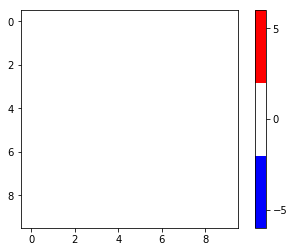

In [39]:
mappy.visualize_map()

In [40]:
BETA_MAP = np.ndarray((10,10))

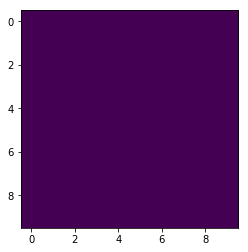

In [46]:
pyplot.imshow(BETA_MAP) 

In [47]:
BETA_MAP[0,0] = 1 

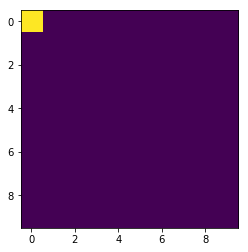

In [48]:
pyplot.imshow(BETA_MAP) 

In [ ]:
def map_to_graph():
    """
    Takes simple array map and turns it into a standard graph representation for algorithm usage.
    
    args: map (np.ndarray) - 
    
    returns: graph ()
    """

In [ ]:
class Itinerary():
    """
    TODO: Docstring
    """
    def __init__():
        pass
    
    def add_passenger():
        

In [ ]:
class MetricsPackage(ABC):
    """
    TODO: Docstring
    Generic metrics package that should be extensible for many situations using similar simulation/ same simulator
    """
    

In [157]:


class AbstractSOPOptimizer(ABC):
    """
    TODO: Docstring
    Strategy pattern to 
    """
    @abstractmethod
    def __init__(self):
        pass
    

class DumbSOPOptimizer(AbstractSOPOptimizer):
    """
    Optimizer that simply uses Euclidean (or Manahattan) distance to choose destination
        ordering by nearness /only/ to current position. 
    """
    def __init__(self):
        self.destination_sequence = []
        
    def optimize_destination_sequence(itinerary):
        
        
    
class BruteForceSOPOptimizer(AbstractSOPOptimizer):
    """
    TODO: Docstring
    """
    def __init__():
        pass
    
class GrassFireSOPOptimizer(AbstractSOPOptimizer):
    """
    TODO: Docstring
    """
    def __init__():
        pass
    
class MSTSOPOptimizer(AbstractSOPOptimizer):
    """
    TODO: Docstring
    """
    def __init__():
        pass
    
class NPResearchSOPOptimizer(AbstractSOPOptimizer):
    """
    TODO: Docstring
    """
    def __init__():
        pass

IndentationError: expected an indented block (<ipython-input-157-7c43b0d18be8>, line 26)

In [57]:
TrivialOptimizer()